In [146]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import matplotlib.pyplot as plt

In [147]:
FOLDER = "subjects"
dateparse = lambda x: datetime.strptime(x[:-6], "%Y-%m-%d %H:%M:%S.%f")

In [148]:

accelData = pd.read_csv(os.path.join(FOLDER, 'sub1-rp-s1.csv'), index_col=0, parse_dates=['loggingTime.txt.'], date_parser=dateparse)

/tmp/ipykernel_323977/4118462216.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  accelData = pd.read_csv(os.path.join(FOLDER, 'sub1-rp-s1.csv'), index_col=0, parse_dates=['loggingTime.txt.'], date_parser=dateparse)


In [149]:
# convert time to seconds and normalize to first sample
start_time = accelData['loggingTime.txt.'][0]
accelData['time.ms'] = (accelData['loggingTime.txt.'] - start_time).dt.total_seconds() * 1000

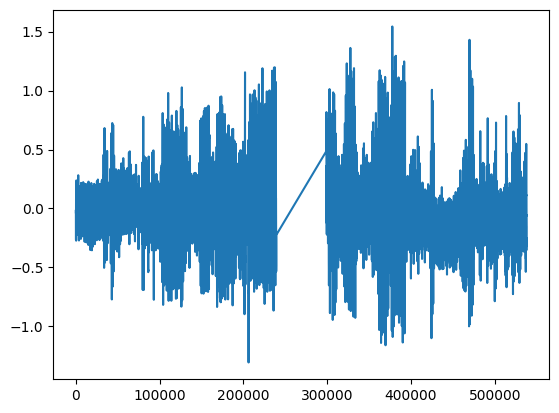

In [150]:
plt.plot(accelData['time.ms'], accelData['motionUserAccelerationX.G.'])

In [151]:
# find the time gap in the data that separates the subject's route A->B and B->A.
# remove the route B->A, so we can work with one contiguous span of measurements rather than 2.

sample_period: pd.Series = (accelData['time.ms'].shift(-1) - accelData['time.ms']).dropna()
# Gap should be found if where the period is >1 second long
gap_indices = sample_period[sample_period > 1000]
if gap_indices.size:
    accelData = accelData.iloc[:gap_indices.index[0] + 1]
    sample_period = sample_period[:gap_indices.index[0] + 1]

avg_sample_period_ms = np.average(sample_period)

In [152]:
print(f"avg sample period: {avg_sample_period_ms} ms")
print(f"frequency: {1000/avg_sample_period_ms} Hz")

avg sample period: 12.463166666666666 ms
frequency: 80.23643001377393 Hz


In [153]:
from scipy import signal
freq = 1000/avg_sample_period_ms

b, a = signal.butter(3, 0.1, btype='lowpass', analog=False)
lowpassed_x = signal.filtfilt(b, a, accelData['motionUserAccelerationX.G.'])
lowpassed_y = signal.filtfilt(b, a, accelData['motionUserAccelerationY.G.'])
lowpassed_z = signal.filtfilt(b, a, accelData['motionUserAccelerationZ.G.'])

fit_x = sp.stats.linregress(x=accelData['time.ms'].values, y=lowpassed_x)
fit_y = sp.stats.linregress(x=accelData['time.ms'].values, y=lowpassed_y)
fit_z = sp.stats.linregress(x=accelData['time.ms'].values, y=lowpassed_z)

line_x = (fit_x.intercept + accelData['time.ms']*fit_x.slope).values
line_y = (fit_y.intercept + accelData['time.ms']*fit_y.slope).values
line_z = (fit_z.intercept + accelData['time.ms']*fit_z.slope).values


In [154]:
N_SAMPLES = -1 # Change number to look at smaller parts of the plot

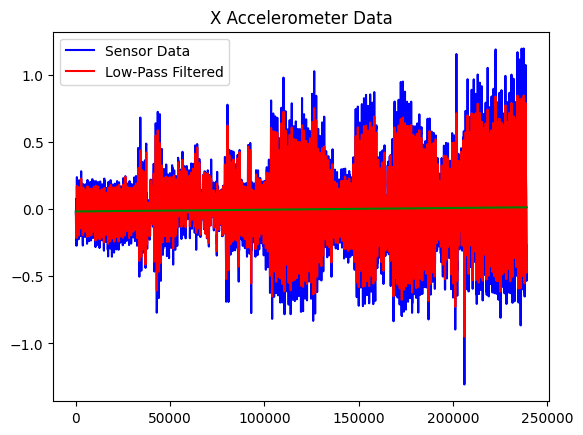

In [155]:

plt.plot(accelData['time.ms'][:N_SAMPLES], accelData['motionUserAccelerationX.G.'][:N_SAMPLES], 'b-')
plt.plot(accelData['time.ms'][:N_SAMPLES], lowpassed_x[:N_SAMPLES], 'r-')
plt.plot(accelData['time.ms'][:N_SAMPLES], line_x[:N_SAMPLES], 'g-')
plt.title("X Accelerometer Data")
plt.legend(['Sensor Data', "Low-Pass Filtered"])
plt.show()

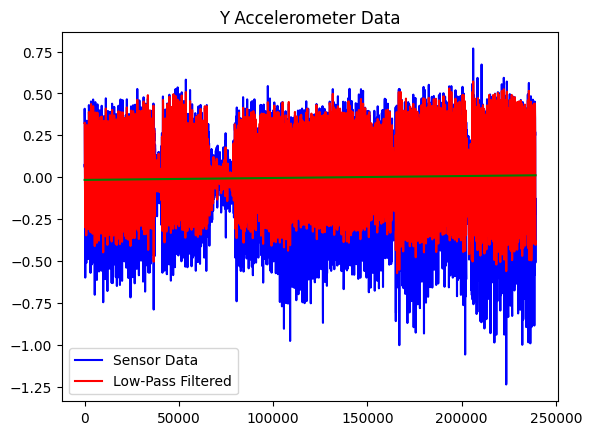

In [156]:
plt.plot(accelData['time.ms'][:N_SAMPLES], accelData['motionUserAccelerationY.G.'][:N_SAMPLES], 'b-')
plt.plot(accelData['time.ms'][:N_SAMPLES], lowpassed_y[:N_SAMPLES], 'r-')
plt.plot(accelData['time.ms'][:N_SAMPLES], line_y[:N_SAMPLES], 'g-')
plt.title("Y Accelerometer Data")
plt.legend(['Sensor Data', "Low-Pass Filtered"])
plt.show()

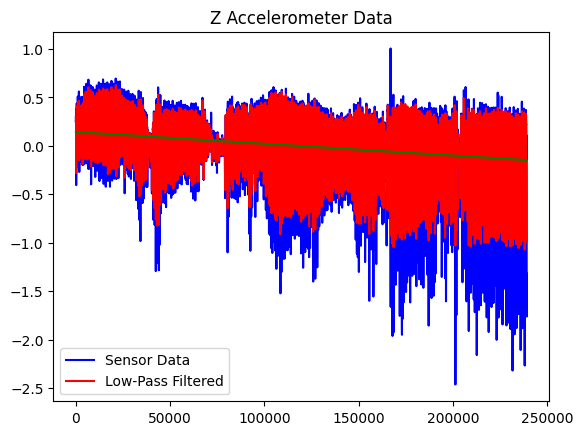

In [157]:
plt.plot(accelData['time.ms'][:N_SAMPLES], accelData['motionUserAccelerationZ.G.'][:N_SAMPLES], 'b-')
plt.plot(accelData['time.ms'][:N_SAMPLES], lowpassed_z[:N_SAMPLES], 'r-')
plt.plot(accelData['time.ms'][:N_SAMPLES], line_z[:N_SAMPLES], 'g-')
plt.title("Z Accelerometer Data")
plt.legend(['Sensor Data', "Low-Pass Filtered"])
plt.show()

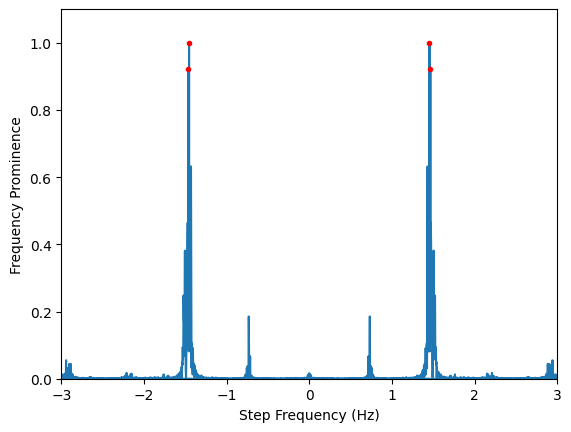

In [161]:
# Finding natural frequency
from scipy.fftpack import fft, fftfreq

zeroed_data = lowpassed_y - line_y
x_fft = fft(zeroed_data)
pwr_density = np.abs(x_fft) ** 2
step_freq = fftfreq(len(pwr_density), avg_sample_period_ms / 1000)
pwr_density /= np.max(pwr_density)
peaks, _ = signal.find_peaks(pwr_density, prominence=0.8)

plt.plot(step_freq, pwr_density)
plt.plot(step_freq[peaks], pwr_density[peaks], 'r.', alpha=1)
plt.axis([-3, 3, 0, 1.1])
plt.xlabel("Step Frequency (Hz)")
plt.ylabel("Frequency Prominence")
plt.show()

In [162]:
np.average(np.abs(step_freq[peaks]), weights=pwr_density[peaks])

np.float64(1.4590950349079261)